In [18]:
import pennylane as qml
from pennylane import numpy as np
from scipy.optimize import minimize
from modules.rl_qaoa import *
from modules.data_process import add_constraint
import random
import json
# Define QAOA depth
def data_to_QUBO(matrix,hamming_weight,l):
    return -np.diag([1]*len(matrix))+matrix/hamming_weight*l
def QpasqalOptimized(matrix, number):
    res = copy.deepcopy(matrix)
    N = res.shape[0]
    for i in range(N):
        res[i][i] = 0
    # 대각 성분 0으로 만들기
    for i in range(N):
        for j in range(i + 1, N):
            res[i][j] = res[i][j] + (matrix[i][i] + matrix[j][j]) / ((number - 1) * 2)
            res[j][i] = res[j][i] + (matrix[i][i] + matrix[j][j]) / ((number - 1) * 2)


    return res

"""
여기값 재훈 : 15,16

세현 : 500,501

성근 : 200,201
"""
cal_list = [0,1]

In [19]:
## Optimization with randomstate
# Initial parameters for QAOA
#from modules.rl_qaoa import RL_QAA

QAOA_list = []
for i in range(4):
    depth =1
    size = 9
    seed = 50
    hamming_weight = 4
    penalty = 1
    with open(f"./data/matrices{size}by{size}.json", "r") as f:
        matrices_data = json.load(f)

    # Generate a QUBO matrix that is challenging for classical QAOA optimization

    Q = data_to_QUBO(np.array(matrices_data[cal_list[i]]),hamming_weight,3)
    Q_cal = zero_lower_triangle(Q + add_constraint([1]*size,hamming_weight)*penalty)



    n = Q.shape[0]
    n_c = 2


    init_params = np.reshape(np.array([0,  0.]*(n-n_c)),-1)


    # RL-QAOA setup
    rl_qaoa_beta = RL_QAA(Q_cal,n,np.array([[100.]*int((n**2)) for i in range(n-n_c)]),learning_rate_init=0.5)
    final_config = rl_qaoa_beta.rqaoa_execute()
    rl_qaoa_beta.n_c =n_c 
    print(f"classical_result : {float(final_config[2])},best : {rl_qaoa_beta.node_assignments}" )


    # Execute RQAOA
    final_config = rl_qaoa_beta.RL_QAOA(episodes=50,epochs=100,log_interval=25,correct_ans=float(final_config[2]))
    QAOA_list.append([rl_qaoa_beta.avg_values,float(final_config[2])])

classical_result : -2.4395037306346015,best : [1, -1, 1, -1, 1, 1, 1, -1, -1]


Epoch 1/100:   0%|          | 0/50 [00:04<?, ? episode/s]


KeyboardInterrupt: 

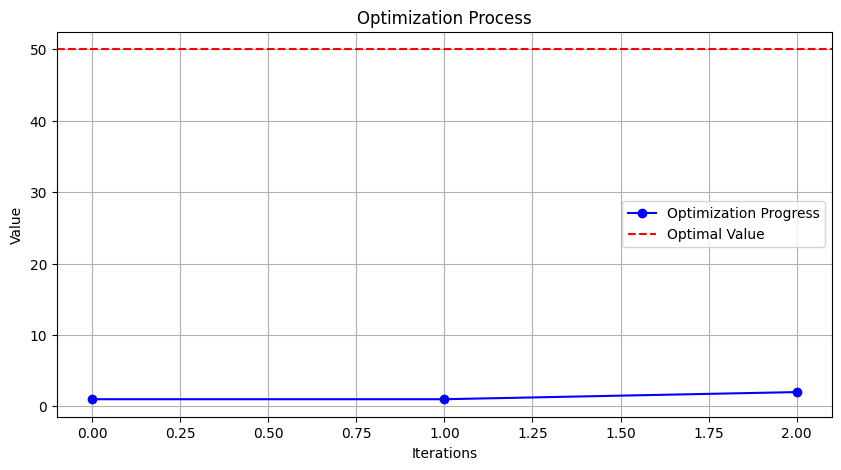

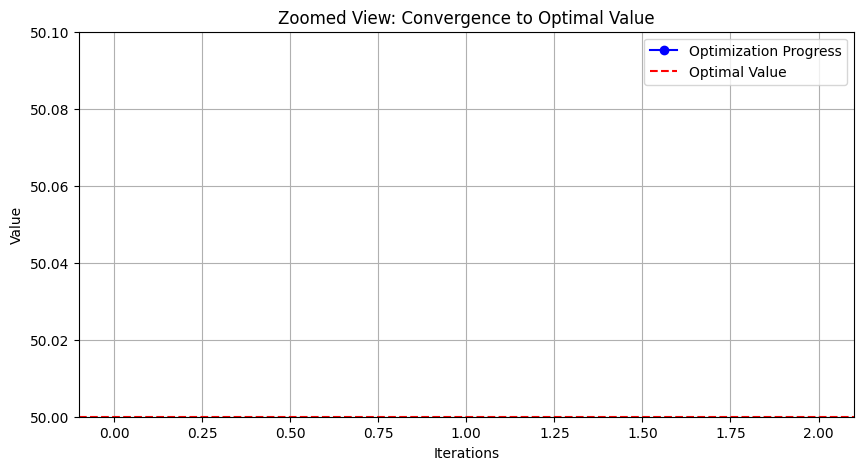

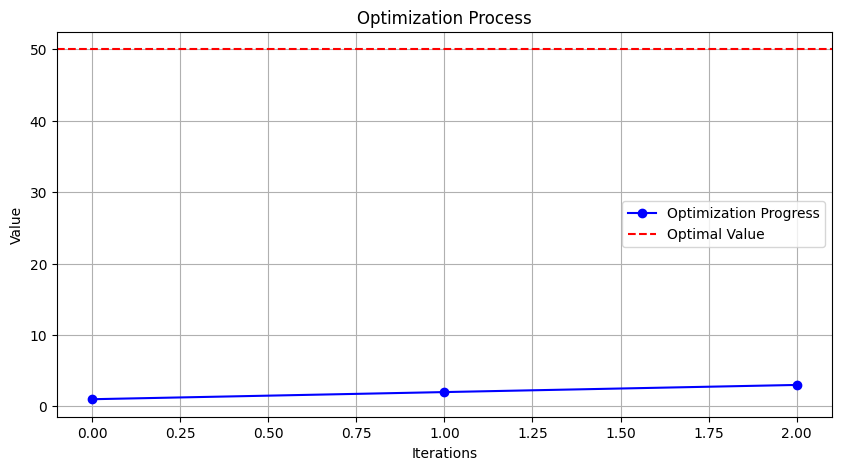

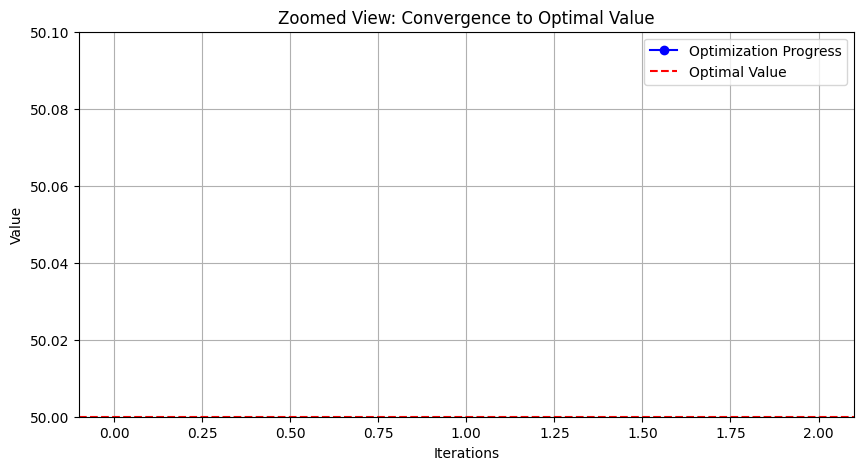

In [ ]:
from matplotlib import pyplot as plt



for data_config in QAOA_list:
    data = data_config[0]
    optimal_value = data_config[1]
    plt.figure(figsize=(10, 5))
    plt.plot(data, marker='o', linestyle='-', color='b', label="Optimization Progress")
    plt.axhline(y=optimal_value, color='r', linestyle='--', label="Optimal Value")
    plt.xlabel("Iterations")
    plt.ylabel("Value")
    plt.title("Optimization Process")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(data, marker='o', linestyle='-', color='b', label="Optimization Progress")
    plt.axhline(y=optimal_value, color='r', linestyle='--', label="Optimal Value")

    plt.ylim(optimal_value, optimal_value + 0.1)
    plt.xlabel("Iterations")
    plt.ylabel("Value")
    plt.title("Zoomed View: Convergence to Optimal Value")
    plt.legend()
    plt.grid(True)
    plt.show()